In [41]:
from matplotlib import pyplot as plt
from tabulate import tabulate
import numpy as np
import cv2

In [42]:
# Steps

NNN = 512

T_STEP = int(40 / 20) + 1
I_STEP = int(NNN / 40) + 1

%run -i ./ownlib/PHT-Library.ipynb
%run -i ./ownlib/RIW-Library2.ipynb
%run -i ./ownlib/Utility.ipynb
%run -i ./ownlib/Inverse-Geometric.ipynb

In [43]:
# Import images
ori_img = cv2.imread('./assets/lena.png') #BGR
ori_logo = cv2.imread('./assets/paperplane.png', 0)

In [44]:
def ecute(N, G, P, D):
    # Preprocess Image
    IMG_BGR = cv2.resize(ori_img, (N, N)) # Original Image
    IMG_Y = getYFromBGR(IMG_BGR) #

    # Preprocess Logo
    LOGO = cv2.resize(ori_logo, (G,G))
    LOGO = (LOGO >= 128) * 1
    
    # Scrambling Logo
    LOGO_SC = scramble(LOGO)
    
    # Transform
    MOMEN = transformPHT(IMG_Y, N, P, 'Transform Image, N={} G={} P={} D={}'.format(N, G, P, D))
    
    # Embedding
    QQ = np.floor(np.abs(MOMEN) / D) % 2
    (LOGO_POSITIONED, LOGO_FILTER, maxCapacity) = watermarkEmbed(LOGO, P)
    
    # Calculate Momen Changes
    XI = np.abs(MOMEN) - np.floor(np.abs(MOMEN) / D) * D
    OMEGA = - XI
    OMEGA = OMEGA + D / 2 * (QQ == LOGO_POSITIONED)
    OMEGA = OMEGA + 3 * D / 2 * np.logical_and(QQ != LOGO_POSITIONED, np.logical_or(XI > D / 2, np.abs(MOMEN) < D))
    OMEGA = OMEGA - D / 2 * np.logical_and(QQ != LOGO_POSITIONED, np.logical_and(XI <= D / 2, np.abs(MOMEN) >= D))
    OMEGA = OMEGA / (np.abs(MOMEN) + 0.000000001) * MOMEN
    OMEGA = OMEGA * LOGO_FILTER
    
    # Compensation Image
    IMG_COMPENSATION = inversePHT(OMEGA, N, P, 'Generating Compensation Image N={} G={} P={} D={}'.format(N, G, P, D ))
    
    # Watermarking
    IMG_Y_WATERMARKED = IMG_Y + IMG_COMPENSATION
    IMG_WATERMARKED = putYToBGR(IMG_Y_WATERMARKED, IMG_BGR)
    
    # Calculate PSNR
    DST = (IMG_WATERMARKED - IMG_BGR)
    DST = DST * DST
    MSE = np.sum(DST) / (9 * N * N)
    PSNR = 10 * np.log10(255 * 255 / MSE)
    
    # Return
    return (IMG_WATERMARKED, PSNR, N, G, P, D)

In [45]:
def war(image, n):
    attackedImages = []
    
    # No Attack
    attackedImages.append((np.copy(image), 'No Attack'))
    
    # Attack: Rotation
    ROTATION_ANGLE = 45
    imgRotate = attackRotation(image, ROTATION_ANGLE)
    attackedImages.append((imgRotate, 'Rotation {}° CW'.format(ROTATION_ANGLE)))
    
    # Attack: Scaling
    RESIZE_FACTOR = 0.75
    imgResize = attackResize(image, int(RESIZE_FACTOR * n))
    attackedImages.append((imgResize, 'Scaling ' + '{:.0%}'.format(RESIZE_FACTOR)))
    
    # Attack: Translation
    TR_X = 0.05
    TR_Y = -0.05
    imgTranslate = attackTranslate(image, TR_X, TR_Y)
    attackedImages.append((imgTranslate, 'Translation X={:.0%} Y={:.0%}'.format(TR_X, TR_Y)))
    
    # Attack: Crop
    CROP_PERCENTAGE = 0.05
    imgCrop = attackCrop(image, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE)
    attackedImages.append((imgCrop, 'Crop {:.0%}'.format(CROP_PERCENTAGE)))
    
    # Attack: BLUR
    BLUR_KERNEL_SIZE = 3
    imgBlur = attackBlur(image, BLUR_KERNEL_SIZE)
    attackedImages.append((imgBlur, 'Blur K={}'.format(BLUR_KERNEL_SIZE)))

    # Attack: Black & Pepper Noise
    NOISE_PERCENTAGE = 0.05
    imgNoise = attackRandomNoise(image, NOISE_PERCENTAGE)
    attackedImages.append((imgNoise, 'Noise {:.0%}'.format(NOISE_PERCENTAGE)))

    # Attack: JPG Compression
    COMPRESSION_QUALITY = 60
    imgJpg = attackJPG(image, ROTATION_ANGLE)
    attackedImages.append((imgJpg, 'JPG Compression Q={}'.format(COMPRESSION_QUALITY)))
    
    return attackedImages

In [46]:
# Different Max Momen

IMW_32_X_035 = []
for pp in (40, 50, 60, 70):
    pair = ecute(NNN, 32, pp, 0.35)
    IMW_32_X_035.append(pair)
    
TEST_P_HEADER = ['N', 'G', 'P', 'D', 'PSNR']
TEST_P = []

for pair in IMW_32_X_035:
    (imw, psnr, n, g, p, d) = pair
    TEST_P.append([n, g, p, d, psnr])
#     imgshow1(imw, 'N = {}, G = {}, P = {}, D = {}'.format(n, g, p, d))
    
clear_output(wait = True)
print(tabulate(TEST_P, headers=TEST_P_HEADER, tablefmt='orgtbl'))

|   N |   G |   P |    D |    PSNR |
|-----+-----+-----+------+---------|
| 512 |  32 |  40 | 0.35 | 35.4496 |
| 512 |  32 |  50 | 0.35 | 35.5143 |
| 512 |  32 |  60 | 0.35 | 35.4882 |
| 512 |  32 |  70 | 0.35 | 35.4144 |


In [47]:
IMW_DATA_32_X_035 = []
IMW_GALLERY_32_X_035 = []
IMW_HEADER_32_X_035 = []
for data in IMW_32_X_035[0:]:
    (imgWatermarked, psnr, n, g, p, d) = data
    
    logo = cv2.resize(ori_logo, (g,g))
    logo = (logo >= 128) * 1
    
    imgAttackedList = war(imgWatermarked, n)
    gallery = [logo]
    title = ['Original']
    data = np.array([n, g, p, d, psnr])
    IMW_HEADER_32_X_035 = []
    for imgWithTitle in imgAttackedList[0:]:
        (imgAttack, titleAttack) = imgWithTitle
        IMW_HEADER_32_X_035.append(titleAttack)
        message = 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, titleAttack)
        (logo2, ber) = extractWatermarkFromImage(imgAttack, ori_img, ori_logo, n, g, p, d, message)
        data = np.append(data, ber)
        gallery.append(logo2)
        title.append(titleAttack)
    
    IMW_DATA_32_X_035.append(data)
    IMW_GALLERY_32_X_035.append(([gallery], [title]))

clear_output(wait = True)
IMW_DATA_32_X_035.insert(0, ['N', 'G', 'P', 'D', 'PSNR'] + IMW_HEADER_32_X_035)
IMW_DATA_32_X_035_T = np.array(IMW_DATA_32_X_035).T
print(tabulate(
    IMW_DATA_32_X_035_T,
    tablefmt='orgtbl'
))

| N                      | 512         | 512         | 512          | 512         |
| G                      |  32         |  32         |  32          |  32         |
| P                      |  40         |  50         |  60          |  70         |
| D                      |   0.35      |   0.35      |   0.35       |   0.35      |
| PSNR                   |  35.4496    |  35.5143    |  35.4882     |  35.4144    |
| No Attack              |   0         |   0         |   0          |   0         |
| Rotation 45° CW        |   0.118164  |   0.113281  |   0.00195312 |   0.114258  |
| Scaling 75%            |   0         |   0         |   0          |   0         |
| Translation X=5% Y=-5% |   0.140625  |   0.148438  |   0.152344   |   0.142578  |
| Crop 5%                |   0.0830078 |   0.0849609 |   0.0947266  |   0.0917969 |
| Blur K=3               |   0         |   0         |   0          |   0         |
| Noise 5%               |   0.0234375 |   0.0341797 |   0.0322266  |   0.03

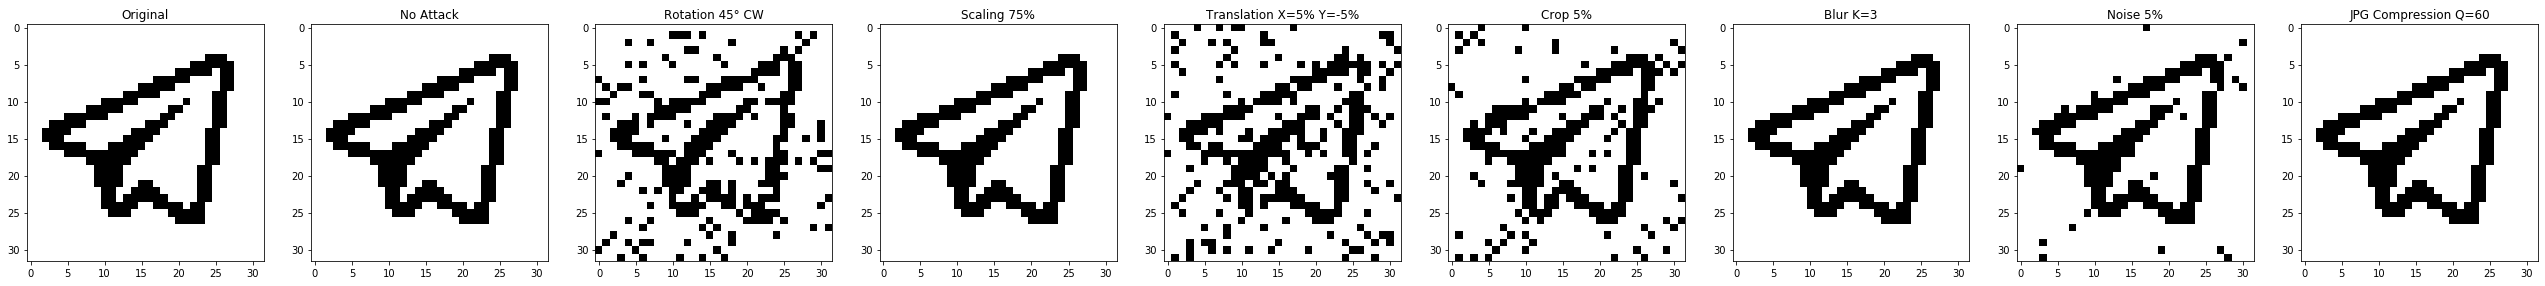

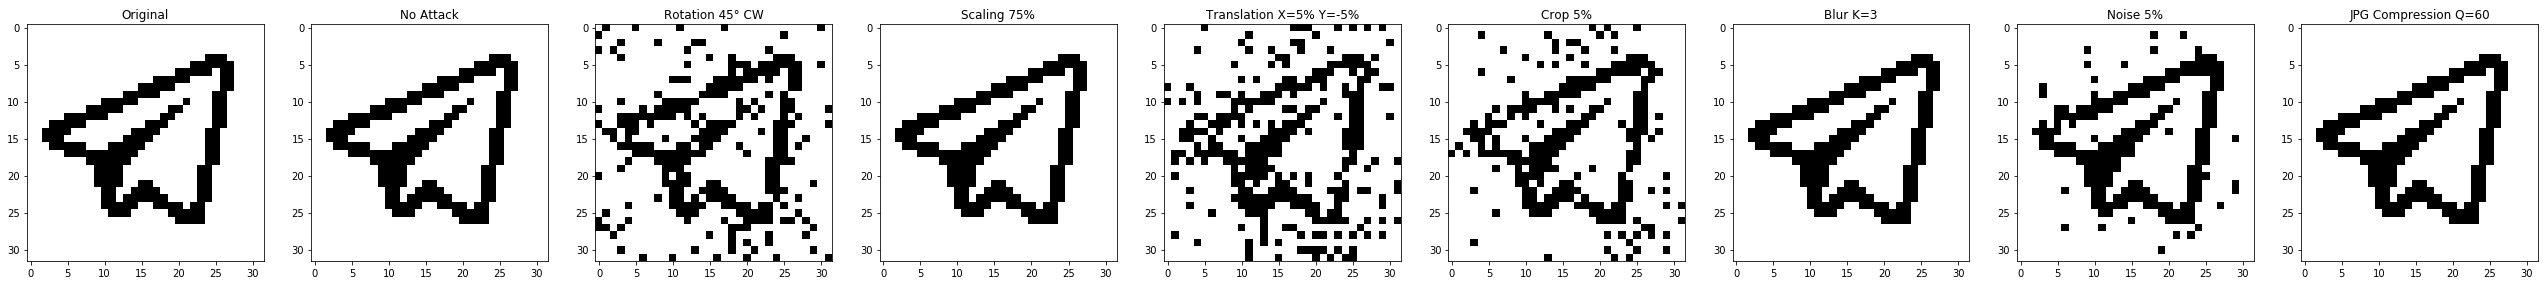

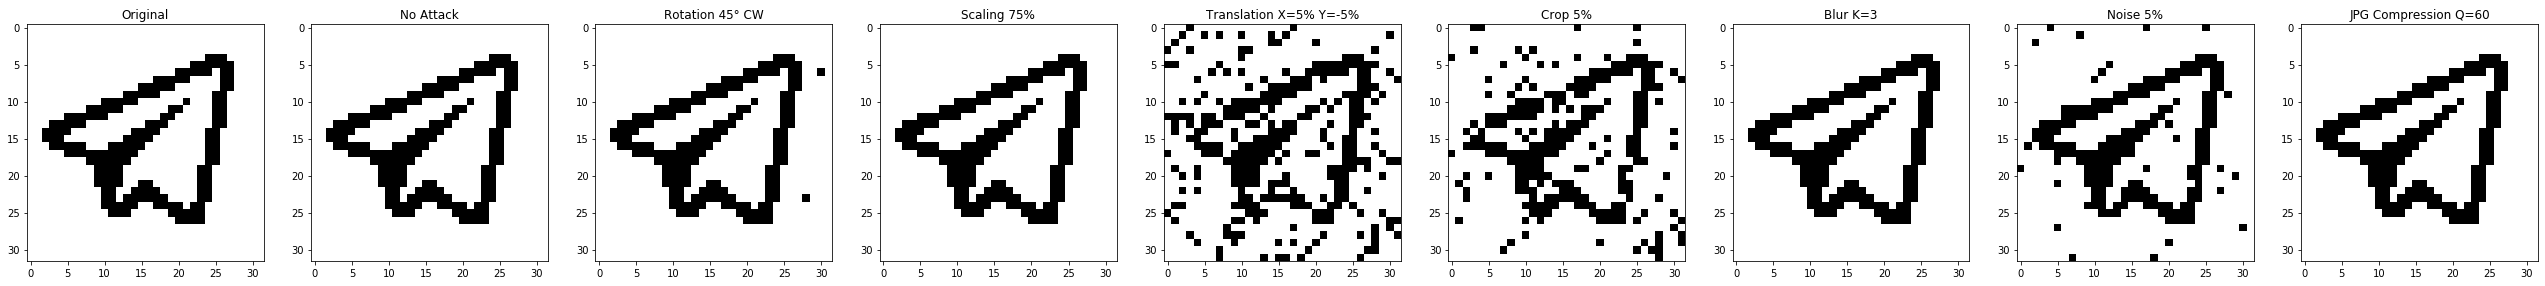

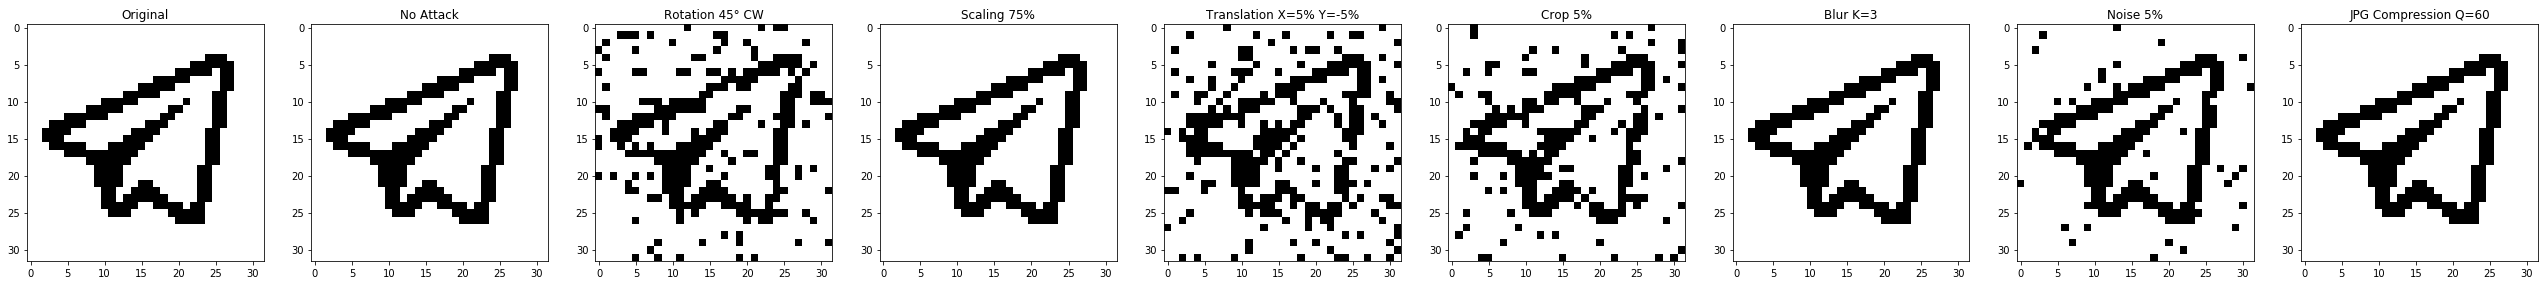

In [48]:
for imageNTitle in IMW_GALLERY_32_X_035:
    (image, title) = imageNTitle
    imgshow(image, title, 5)

In [49]:
# Different Logo Size

IMW_X_50_035 = []
for gg in (8, 16, 24, 32):
    pair = ecute(NNN, gg, 50, 0.35)
    IMW_X_50_035.append(pair)

TEST_G_HEADER = ['N', 'G', 'P', 'D', 'PSNR']
TEST_G = []

for pair in IMW_X_50_035:
    (imw, psnr, n, g, p, d) = pair
    TEST_G.append([n, g, p, d, psnr])
#     imgshow1(imw, 'N = {}, G = {}, P = {}, D = {}'.format(n, g, p, d))

clear_output(wait = True)
print(tabulate(TEST_G, headers=TEST_G_HEADER, tablefmt='orgtbl'))

|   N |   G |   P |    D |    PSNR |
|-----+-----+-----+------+---------|
| 512 |   8 |  50 | 0.35 | 46.4403 |
| 512 |  16 |  50 | 0.35 | 39.3139 |
| 512 |  24 |  50 | 0.35 | 36.8902 |
| 512 |  32 |  50 | 0.35 | 35.5143 |


In [50]:
IMW_DATA_X_50_035 = []
IMW_GALLERY_X_50_035 = []
IMW_HEADER_X_50_035 = []
for data in IMW_X_50_035[0:]:
    (imgWatermarked, psnr, n, g, p, d) = data
    
    imgBgr = cv2.resize(ori_img, (n, n))
    logo = cv2.resize(ori_logo, (g,g))
    logo = (logo >= 128) * 1
    
    imgAttackedList = war(imgWatermarked, n)
    gallery = [logo]
    title = ['Original']
    data = np.array([n, g, p, d, psnr])
    IMW_HEADER_X_50_035 = []
    for imgWithTitle in imgAttackedList[0:]:
        (imgAttack, titleAttack) = imgWithTitle
        IMW_HEADER_X_50_035.append(titleAttack)
        message = 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, titleAttack)
        (logo2, ber) = extractWatermarkFromImage(imgAttack, ori_img, ori_logo, n, g, p, d, message)
        data = np.append(data, ber)
        gallery.append(logo2)
        title.append(titleAttack)
    
    IMW_DATA_X_50_035.append(data)
    IMW_GALLERY_X_50_035.append(([gallery], [title]))

clear_output(wait = True)
IMW_DATA_X_50_035.insert(0, ['N', 'G', 'P', 'D', 'PSNR'] + IMW_HEADER_X_50_035)
print(tabulate(
    np.array(IMW_DATA_X_50_035).T,
    tablefmt='orgtbl'
))

| N                      | 512        | 512         | 512         | 512         |
| G                      |   8        |  16         |  24         |  32         |
| P                      |  50        |  50         |  50         |  50         |
| D                      |   0.35     |   0.35      |   0.35      |   0.35      |
| PSNR                   |  46.4403   |  39.3139    |  36.8902    |  35.5143    |
| No Attack              |   0        |   0         |   0         |   0         |
| Rotation 45° CW        |   0        |   0         |   0.0590278 |   0.113281  |
| Scaling 75%            |   0        |   0         |   0         |   0         |
| Translation X=5% Y=-5% |   0.234375 |   0.210938  |   0.206597  |   0.148438  |
| Crop 5%                |   0.203125 |   0.191406  |   0.133681  |   0.0849609 |
| Blur K=3               |   0        |   0         |   0         |   0         |
| Noise 5%               |   0.171875 |   0.0742188 |   0.03125   |   0.0302734 |
| JPG Compressio

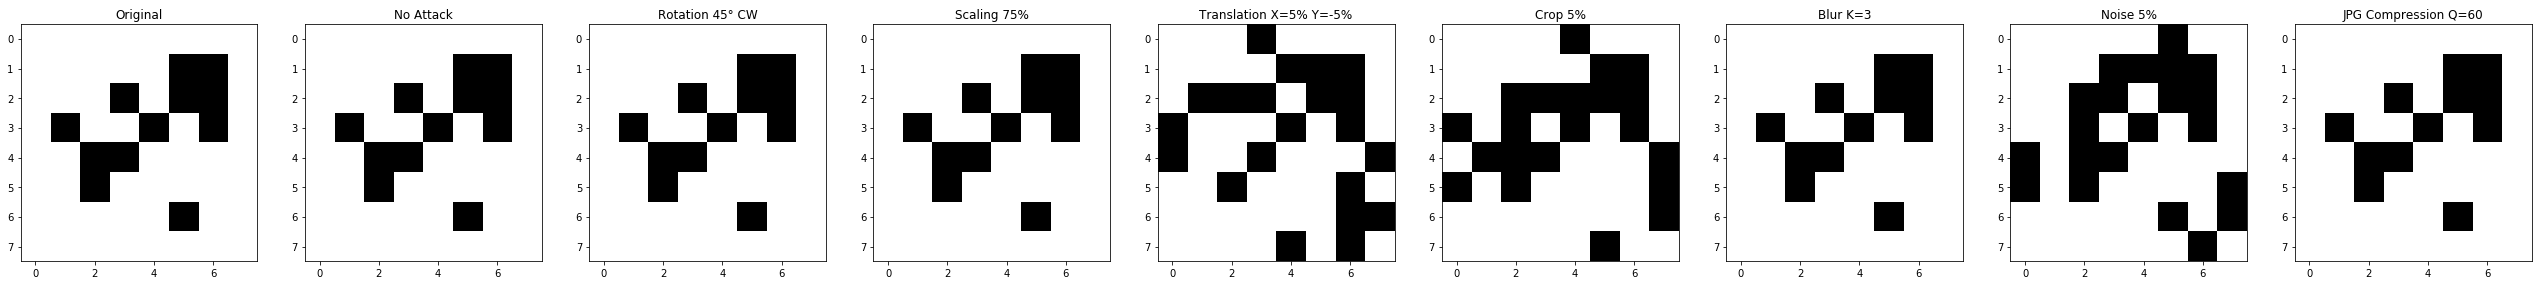

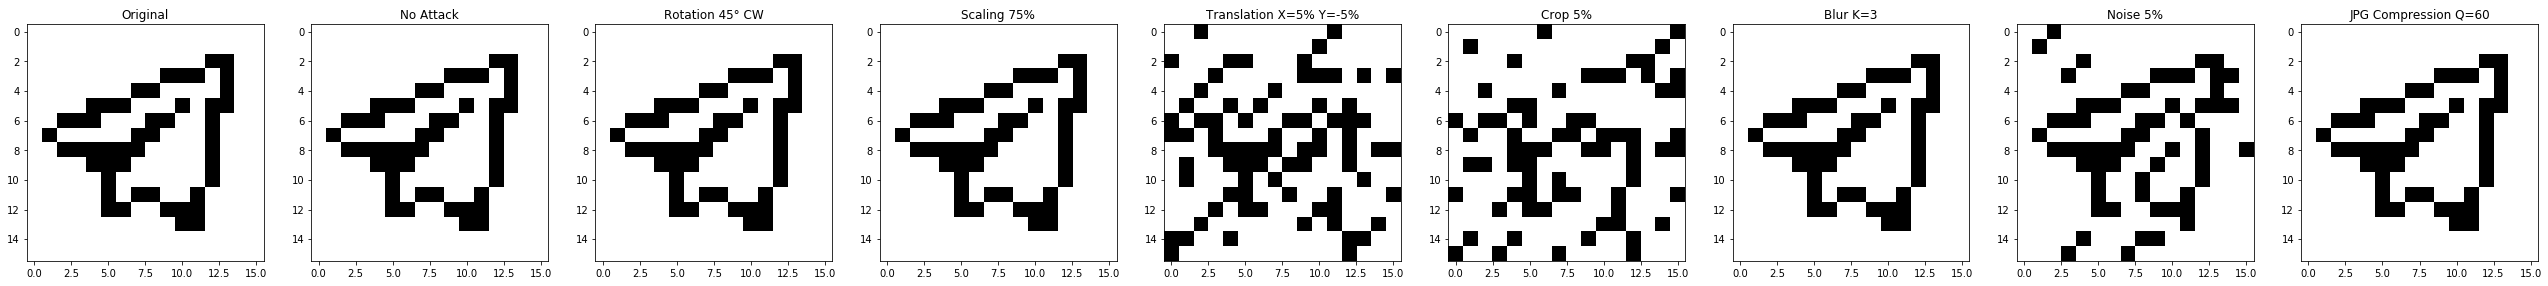

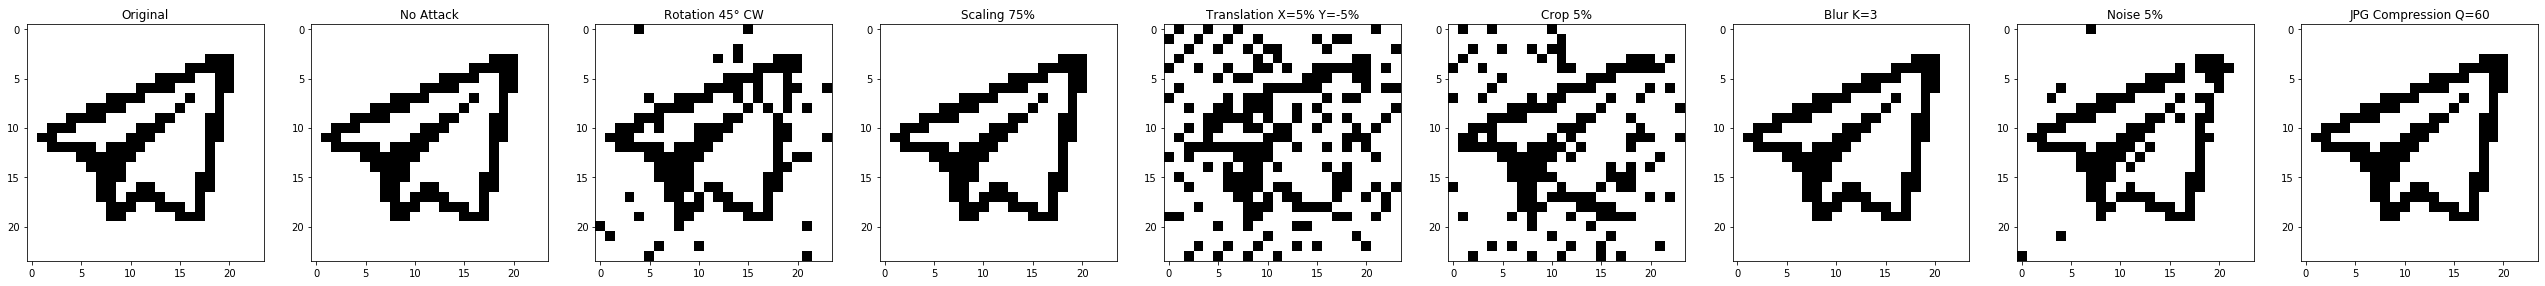

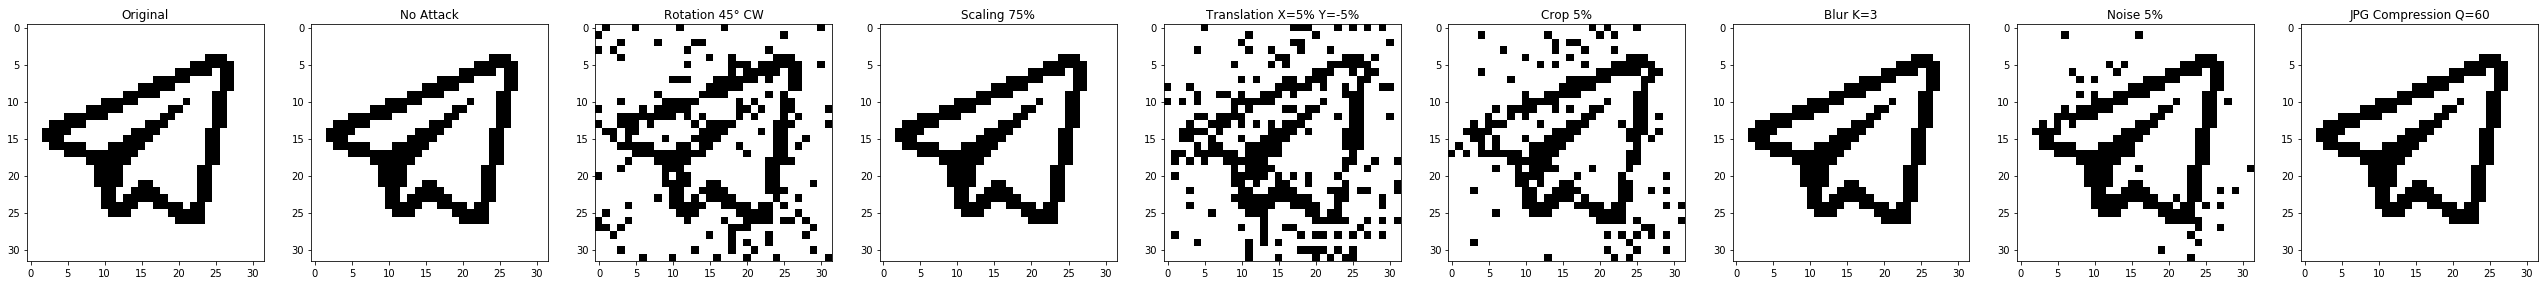

In [51]:
for imageNTitle in IMW_GALLERY_X_50_035:
    (image, title) = imageNTitle
    imgshow(image, title, 5)

In [52]:
# Different Logo Size

IMW_32_50_X = []
for dd in (0.1, 0.2, 0.3, 0.4, 0.5):
    pair = ecute(NNN, 32, 50, dd)
    IMW_32_50_X.append(pair)

TEST_D_HEADER = ['N', 'G', 'P', 'D', 'PSNR']
TEST_D = []

for pair in IMW_32_50_X:
    (imw, psnr, n, g, p, d) = pair
    TEST_D.append([n, g, p, d, psnr])
#     imgshow1(imw, 'N = {}, G = {}, P = {}, D = {}'.format(n, g, p, d))

clear_output(wait = True)
print(tabulate(TEST_D, headers=TEST_D_HEADER, tablefmt='orgtbl'))

|   N |   G |   P |   D |    PSNR |
|-----+-----+-----+-----+---------|
| 512 |  32 |  50 | 0.1 | 44.8338 |
| 512 |  32 |  50 | 0.2 | 38.6689 |
| 512 |  32 |  50 | 0.3 | 36.1408 |
| 512 |  32 |  50 | 0.4 | 35.1043 |
| 512 |  32 |  50 | 0.5 | 34.6064 |


In [53]:
IMW_DATA_32_50_X = []
IMW_GALLERY_32_50_X = []
IMW_HEADER_32_50_X = []
for data in IMW_32_50_X[0:]:
    (imgWatermarked, psnr, n, g, p, d) = data
    
    imgBgr = cv2.resize(ori_img, (n, n))
    logo = cv2.resize(ori_logo, (g,g))
    logo = (logo >= 128) * 1
    
    imgAttackedList = war(imgWatermarked, n)
    gallery = [logo]
    title = ['Original']
    data = np.array([n, g, p, d, psnr])
    IMW_HEADER_32_50_X = []
    for imgWithTitle in imgAttackedList[0:]:
        (imgAttack, titleAttack) = imgWithTitle
        IMW_HEADER_32_50_X.append(titleAttack)
        message = 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, titleAttack)
        (logo2, ber) = extractWatermarkFromImage(imgAttack, ori_img, ori_logo, n, g, p, d, message)
        data = np.append(data, ber)
        gallery.append(logo2)
        title.append(titleAttack)
    
    IMW_DATA_32_50_X.append(data)
    IMW_GALLERY_32_50_X.append(([gallery], [title]))

clear_output(wait = True)
IMW_DATA_32_50_X.insert(0, ['N', 'G', 'P', 'D', 'PSNR'] + IMW_HEADER_32_50_X)
IMW_DATA_32_50_X_T = np.array(IMW_DATA_32_50_X).T
print(tabulate(
    IMW_DATA_32_50_X_T,
    tablefmt='orgtbl'
))

| N                      | 512         | 512        | 512         | 512         | 512         |
| G                      |  32         |  32        |  32         |  32         |  32         |
| P                      |  50         |  50        |  50         |  50         |  50         |
| D                      |   0.1       |   0.2      |   0.3       |   0.4       |   0.5       |
| PSNR                   |  44.8338    |  38.6689   |  36.1408    |  35.1043    |  34.6064    |
| No Attack              |   0         |   0        |   0         |   0         |   0.0771484 |
| Rotation 45° CW        |   0.0595703 |   0.162109 |   0.113281  |   0.117188  |   0.105469  |
| Scaling 75%            |   0         |   0        |   0         |   0         |   0.0996094 |
| Translation X=5% Y=-5% |   0.37793   |   0.226562 |   0.166016  |   0.132812  |   0.1875    |
| Crop 5%                |   0.341797  |   0.170898 |   0.111328  |   0.0751953 |   0.15625   |
| Blur K=3               |   0         |

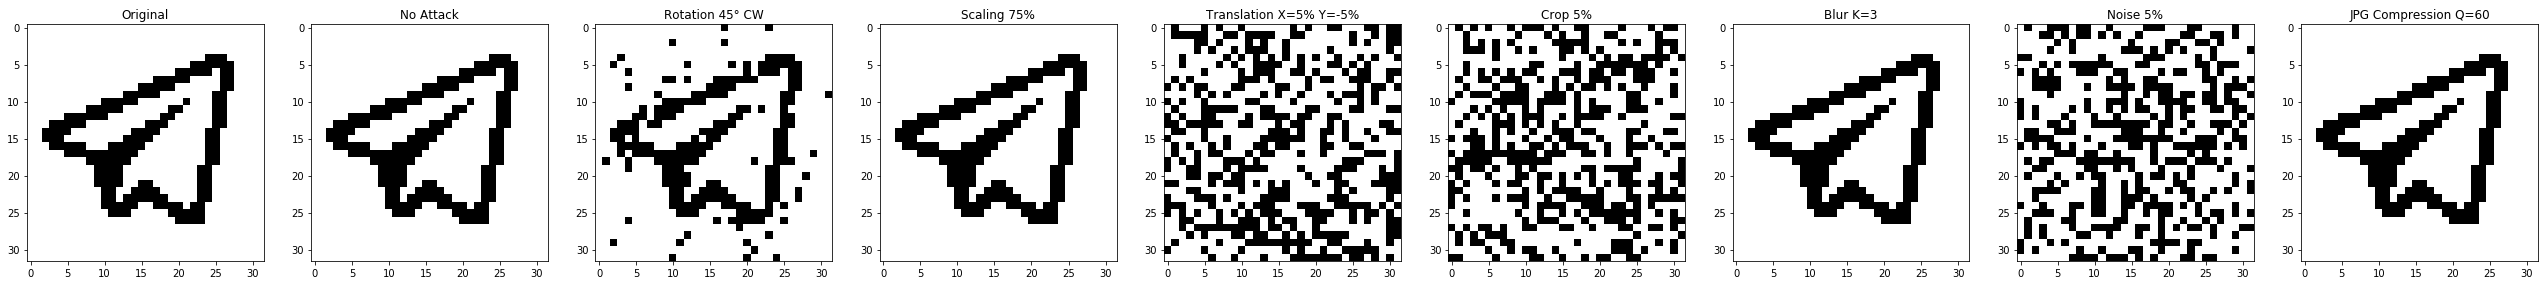

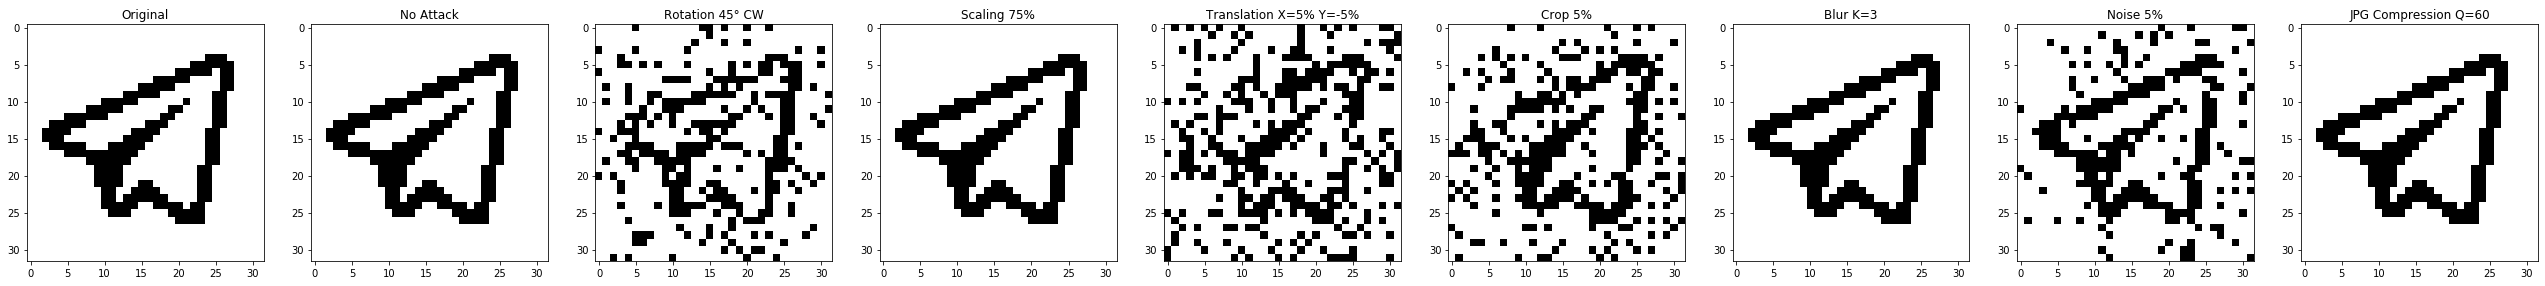

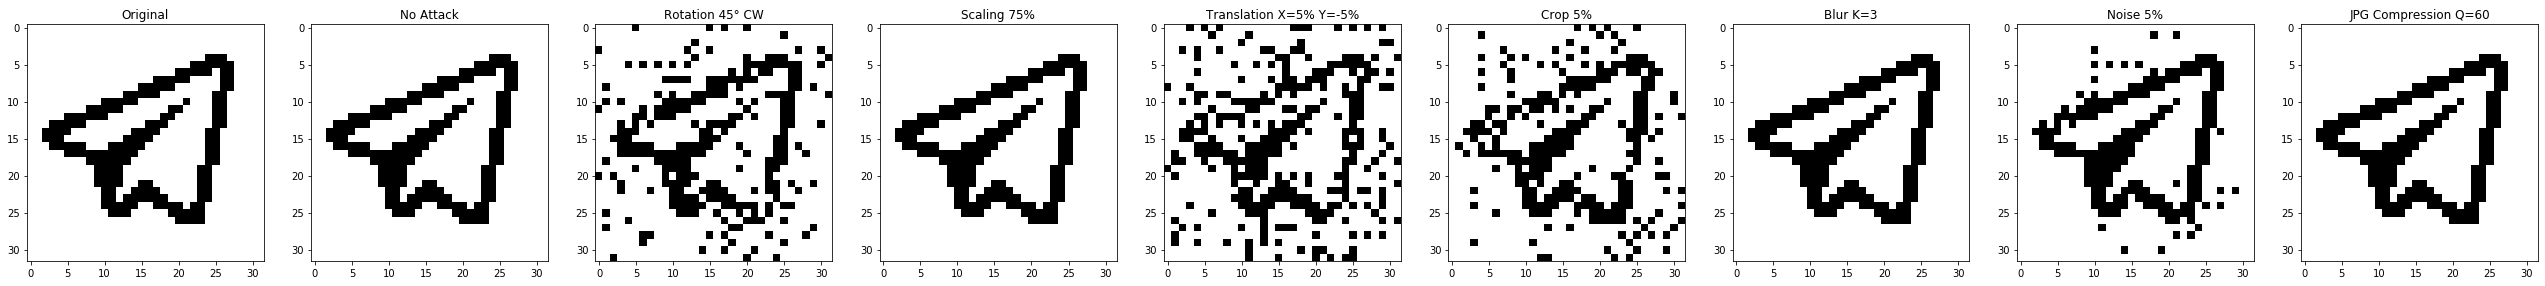

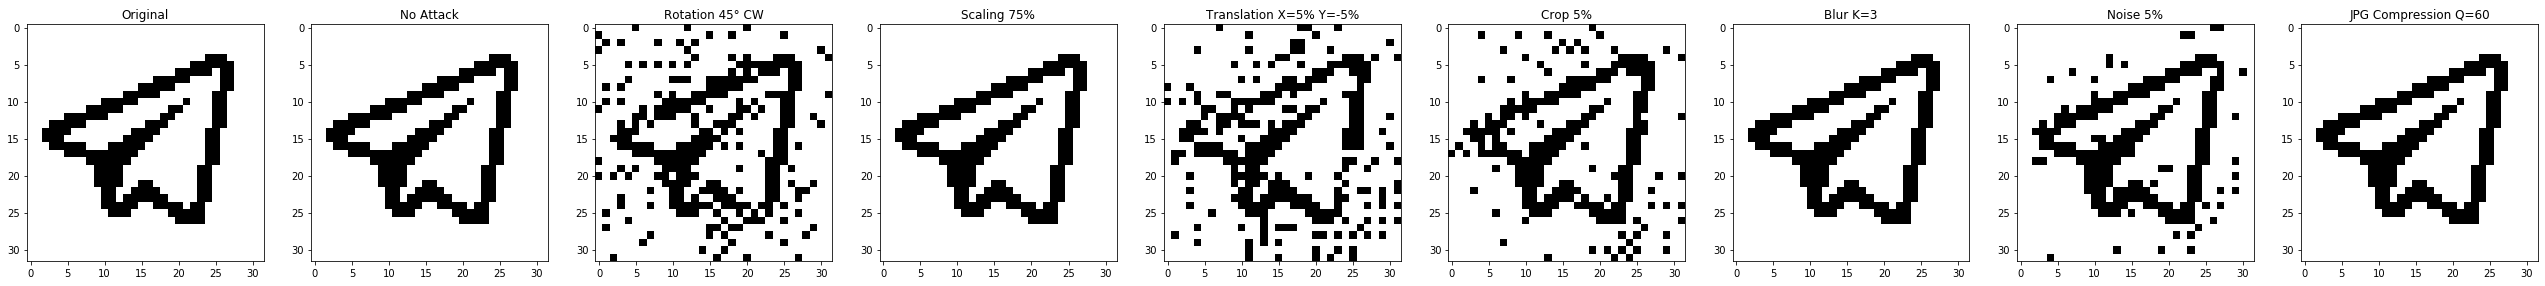

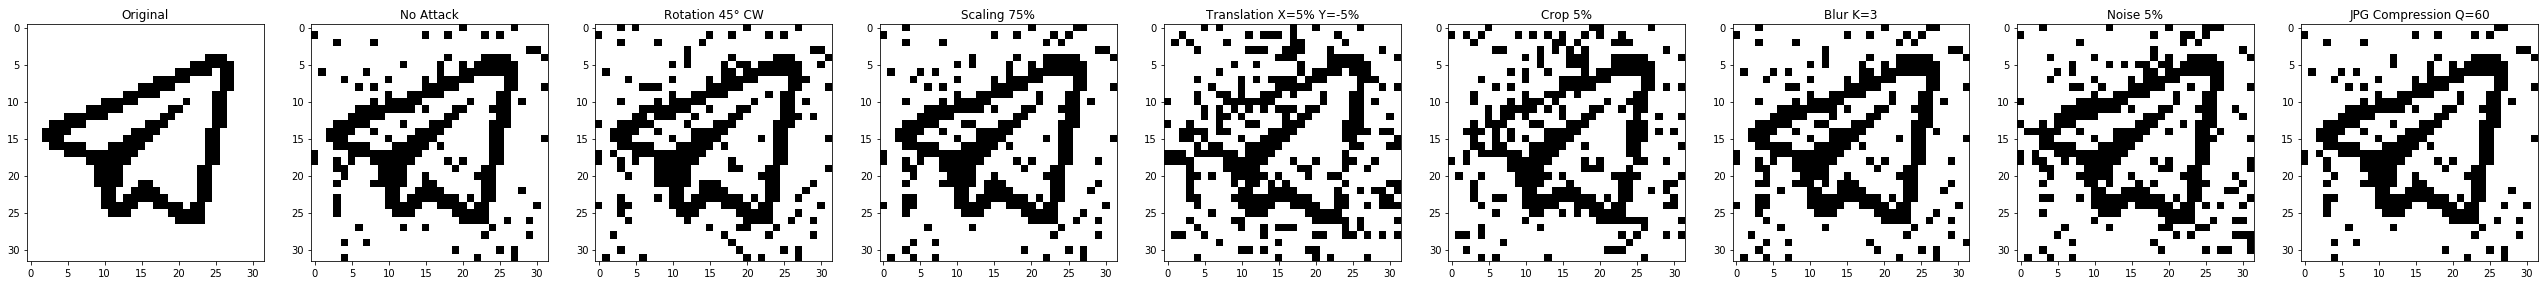

In [54]:
for imageNTitle in IMW_GALLERY_32_50_X:
    (image, title) = imageNTitle
    imgshow(image, title, 5)